# Example of simple SBI

This is a very simple example of simulation-based inference, in which we attempt to learn an inference network that can take a coadded image with exactly two stars in it and estimate the flux of those two stars.  

Some features of the simulations done here.

* Noise properties identical for each exposure.
* No use of variance plane (no simulation of the variance plane either!)
* Simulator can optionally introduce translation artifacts, modelling the idea that the exposures that come together to make a coadd are never going to be pixel-aligned.
* Stars are always about the same distance apart, and the stars are centered in the image
* Only one band of imaging.

Some features of the inference network here.
* Network "knows" there are exactly two stars
* Network preprocesses data by clamping to be nonnegative and applying log1p
* Network is a fairly vanilla convolutional network.

In this notebook we
1. Train a network using simulator *with* translation artifacts (this is considered to be "reality")
2. Train a network using simulator *without* translation artifacts (this is considered to be "our guess at reality")
3. Test both networks on a simulator *with* translation artifacts, and see whether one is better than the other.  That is: does that the fact that we didn't train based on "reality" actually cause problems?

A few remarks
* Running the training part will be very slow on a CPU... you can skip those sections and just use the code below that loads the pretrained models from the `.pt` files
* If you do try to run this on a GPU, change what's commented out
* If you do train, you'll find pytorch makes some random directories where it stores checkpoints.  So that's a thing.
* Here the inference network is trained to estimate the *posterior mean* of both fluxes.  Same principles can be used to extend this to estimating posterior variances etc., but for simplicity in this notebook we're just estimating posterior means.
* This notebook depends on a package break_coadd_sbi that can be found in the same directory as this notebook.  It has some parts.
  * catsampler.py samples catelogs with 2 stars per image
  * imagesampler.py samples images from catalogs
  * dataloader.py has code that uses simulator classes to produce things a neural network trainer likes (a torch "DataLoader" object)
  * convnet.py has the architecture for the neural net
  * dataframelogger.py has code to track the goodness of the neural net as it trains.
* There's a good argument to be made that, as we probably have at least a few hundred images where ground truth is known (e.g., from Gaia) it makes sense to use that data to perform some basic calibration, regardless of what simulator we use.  There are at least two qualitatively different ways this precious ground-truth data could be used.
  * A pre-training calibration step that would try to match the simulator to the truth. That is, the simulator without translation artifacts should be tuned to be *as close as possible* to the simulator with translation artifacts.  Such a step is not included here, but we have experimented with performing such a step.
  * A post-training step to calibrate the trained inference network.  This sort of post-training-calibration step is performed in this notebook, at the end.

# imports

In [1]:
# In case I want to change the break_coadd_sbi package 
# while I'm in the middle of doing stuff in this notebook...
%load_ext autoreload
%autoreload 2

#############################
#############################
#############################
# GPU setup
    
import os
    
    
# don't use any gpus
# os.environ['CUDA_VISIBLE_DEVICES']=""

# use a specific GPU
os.environ['CUDA_VISIBLE_DEVICES']="2"

# if using GPU, allocate cuda memory so other 
# people know i'm using this GPU
import torch # https://pytorch.org/get-started/locally/
x=torch.tensor([0.0],device='cuda') # lock gpu for our use

# if you're running on a 64 core machine, you don't need
# use all 64 cores for this
torch.set_num_threads(8) 

#############################
#############################
#############################
# other modules

import dataclasses
import torch    
import lightning # https://lightning.ai/docs/pytorch/stable/starter/installation.html
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import tqdm.notebook
import IPython
import sklearn.neighbors
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing

matplotlib.rcParams['figure.dpi']=(150)

# define a simple sklearn smoothing model
# we'll use for visualization
binsmoother=sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.KBinsDiscretizer(n_bins=30,strategy='uniform'),
    sklearn.linear_model.LinearRegression()
)

#############################
#############################
#############################
# local modules

# simulation code
from break_coadd_sbi import catsampler
from break_coadd_sbi import imagesampler
from break_coadd_sbi import dataloader

# inference network
from break_coadd_sbi import convnet

# code for logging
from break_coadd_sbi import dataframelogger

# define model (skip this if you're using pretrained simulation models and inference networks)

In [2]:
# skip this if you're using the pretrained *simulation* models
# define model and save

# how catalogs are sampled
prior = catsampler.TwoStarCatalogSimulator(
    center = (20.0,40.0),
    # ... lots of other parameters you could specify here, see code
)

# how images are sampled from catalogs
forward_model = imagesampler.ImageSampler(
    coadd_depth=5,
    height = 40,
    width = 80,
    translation_artifacts=True,
    # ... lots of other parameters you could specify here, see code
)

# an images simulator that "gets it wrong" and doesn't model the translation artifacts
bad_forward_model = dataclasses.replace(forward_model,translation_artifacts=False)

# store it for reproducibility
with open("translation_artifact_question/sims.pkl",'wb') as f:
    pickle.dump((prior,forward_model,bad_forward_model),f)

# load simulation model and make rng

In [3]:
with open("translation_artifact_question/sims.pkl",'rb') as f:
    (prior,forward_model,bad_forward_model) = pickle.load(f)

In [4]:
# random number generator
# which device we use here determines which device the simulator produces 
# its results on
# rng=torch.Generator(device='cpu') # cpu
rng=torch.Generator(device='cuda') # gpu

# look at an example batch

We sample many images all at once (b/c this is more efficient on gpu).

In [5]:
batch_size=64 # say, 64 images

cat=prior.sample_catalogs(batch_size,rng)
imgs=forward_model.sample_images(cat,rng).cpu().numpy() # create images then send back to numpy
imgs_bad=bad_forward_model.sample_images(cat,rng).cpu().numpy()

Ground truth fluxes follow a power-law.

Text(0.5, 0, 'Distribution on ground truth fluxes in this simulator\n(units not meaningful)')

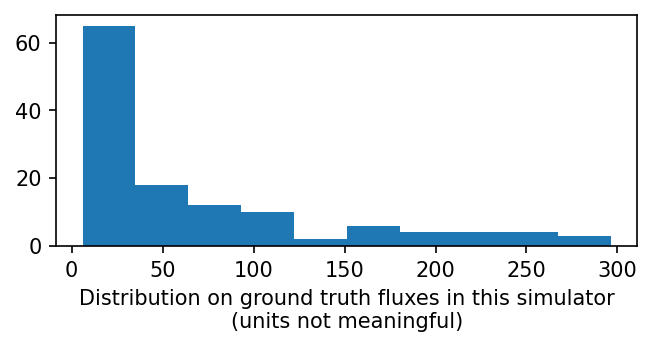

In [6]:
plt.gcf().set_size_inches(5,2)
plt.hist(cat.source_fluxes.cpu().numpy().ravel())
plt.xlabel("Distribution on ground truth fluxes in this simulator\n(units not meaningful)")

Images look like this...

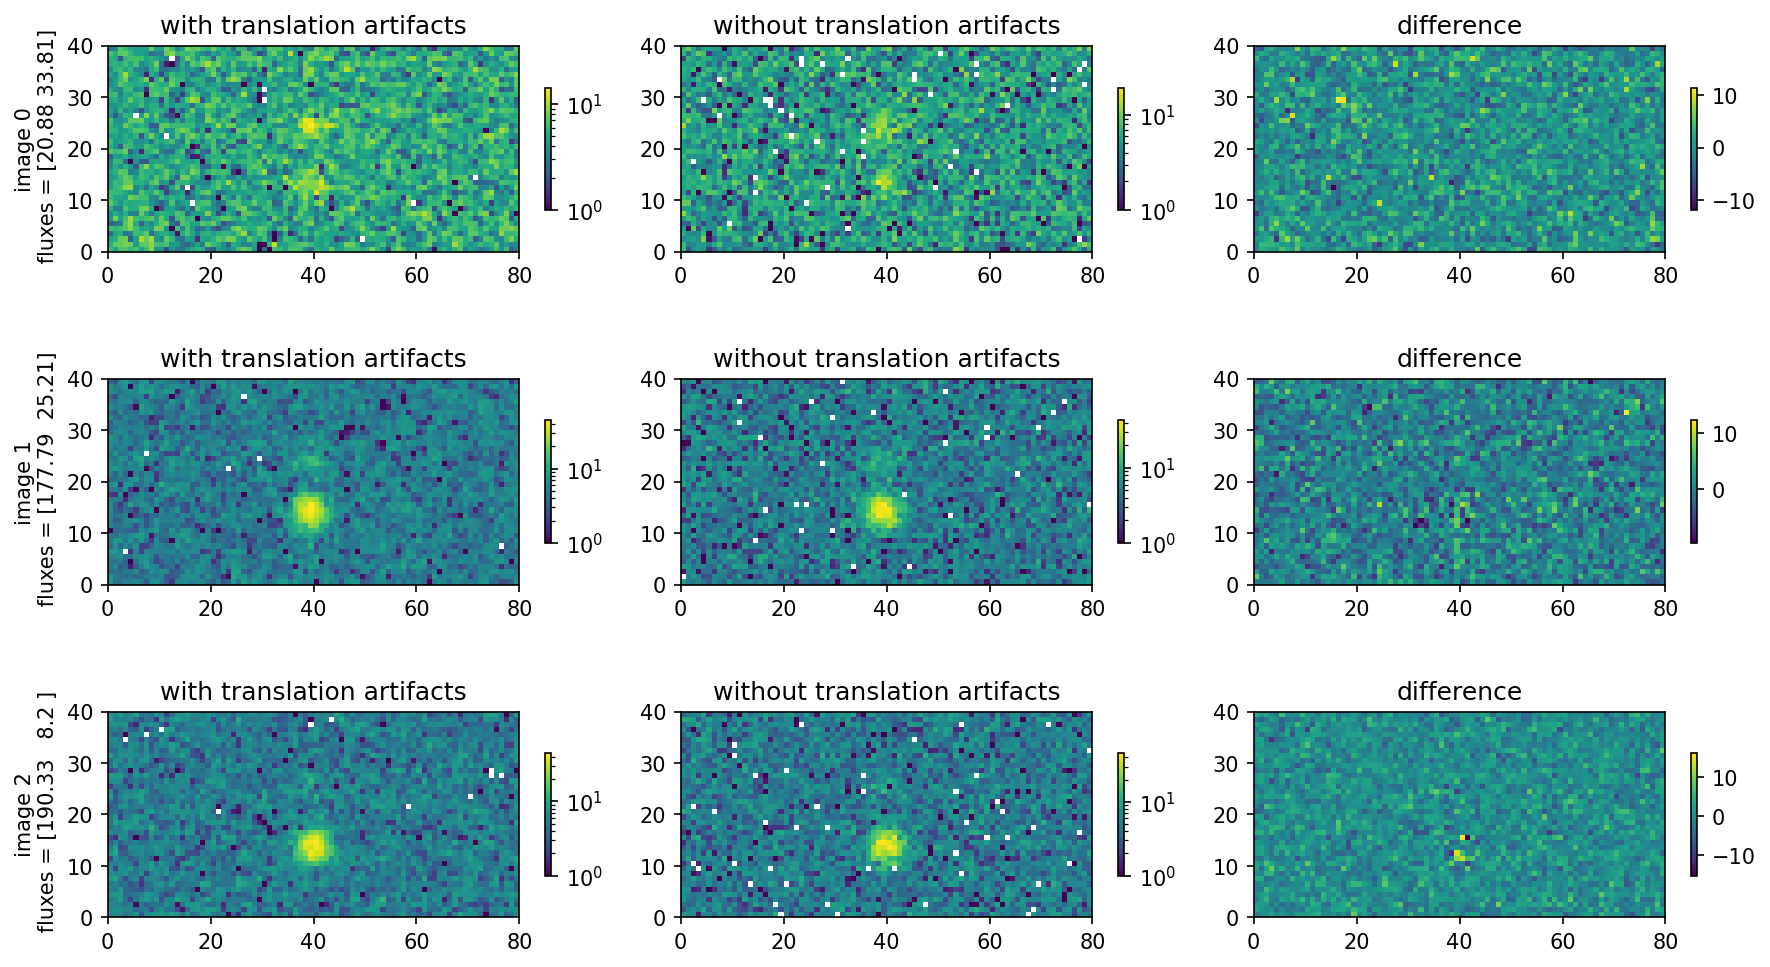

In [7]:
plt.gcf().set_size_inches(12,9)
gs=plt.GridSpec(4,3)
for batch_index in range(3):
    plt.gcf().add_subplot(gs[batch_index,0])
    plt.pcolormesh(imgs[batch_index],norm='log',vmin=1)
    plt.ylabel(f"image {batch_index}\n fluxes = {cat.source_fluxes[batch_index].cpu().numpy().round(2)}");
    plt.colorbar(shrink=.4)
    plt.title(f"with translation artifacts");
    plt.gca().set_aspect('equal')

    plt.gcf().add_subplot(gs[batch_index,1])
    plt.pcolormesh(imgs_bad[batch_index],norm='log',vmin=1)
    plt.title(f"without translation artifacts");
    plt.colorbar(shrink=.4)
    plt.gca().set_aspect('equal')

    plt.gcf().add_subplot(gs[batch_index,2])
    plt.pcolormesh(imgs[batch_index]-imgs_bad[batch_index])
    plt.title(f"difference");
    plt.colorbar(shrink=.4)
    plt.gca().set_aspect('equal')
    
gs.tight_layout(plt.gcf())

We can see that the translation artifacst don't introduce huge difference.  But it's hard to see because of all the nosie.  Let's look at noiseless case.

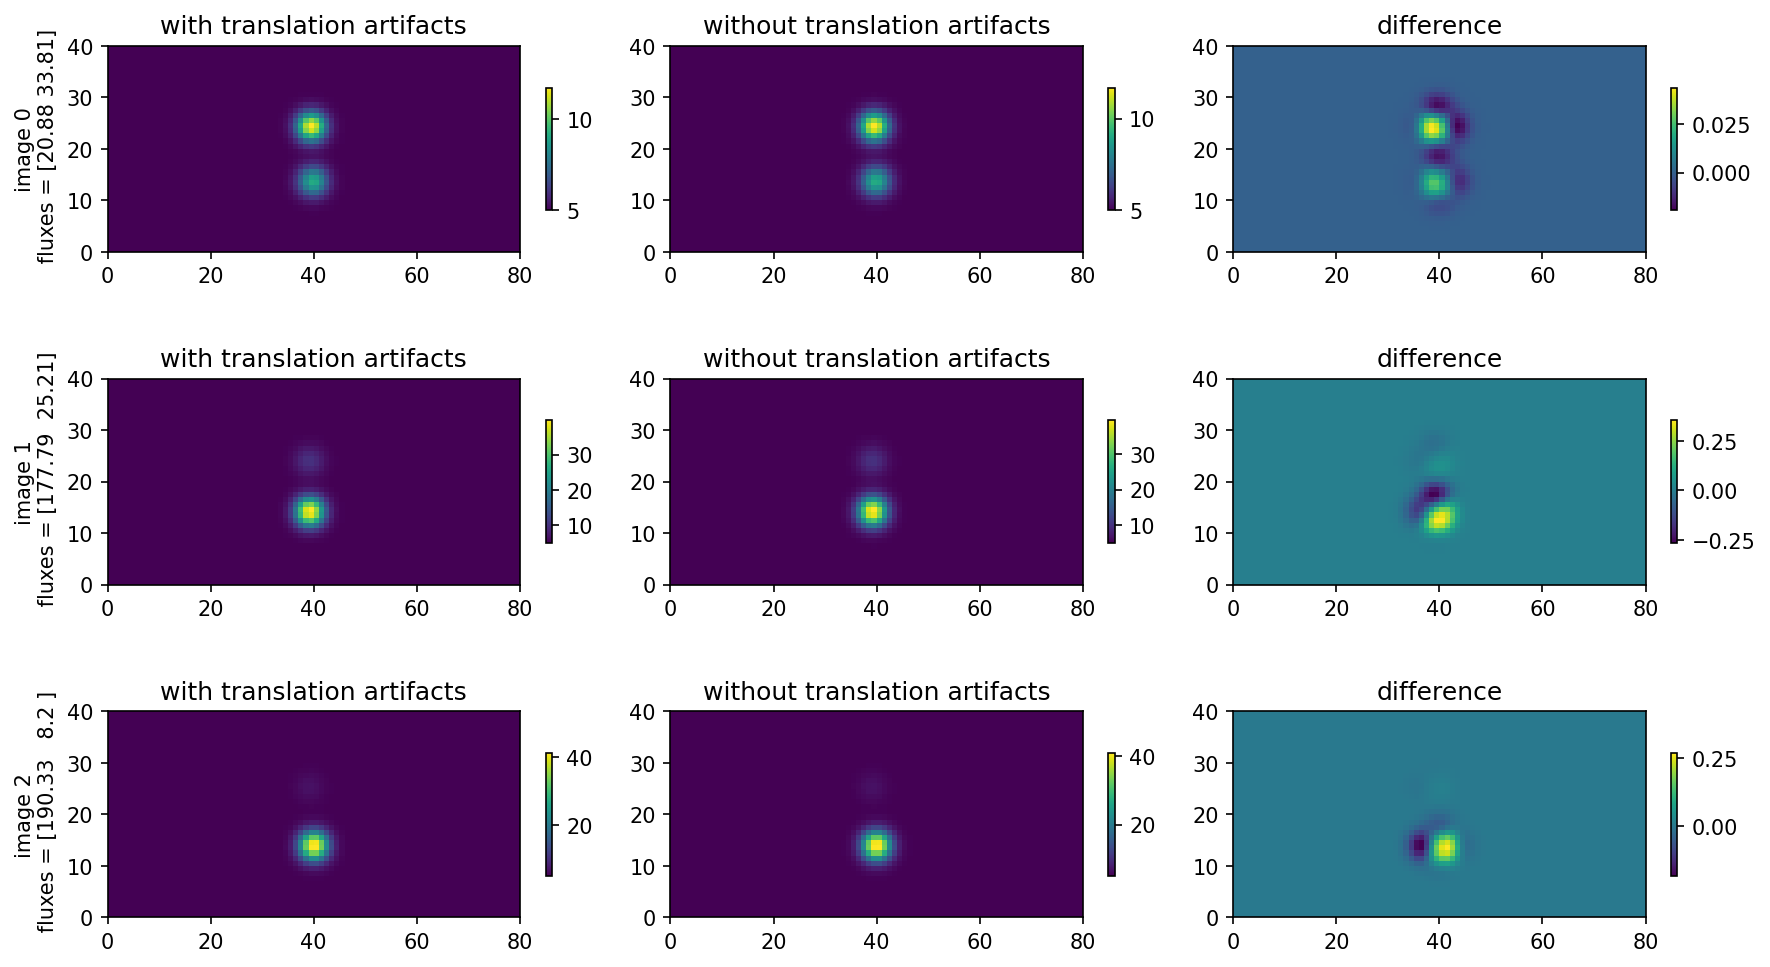

In [8]:
clean_bad_forward_model = dataclasses.replace(bad_forward_model,ccd_b=0,ccd_c=0) # no noise
clean_forward_model = dataclasses.replace(forward_model,ccd_b=0,ccd_c=0) # no noise
imgs=clean_forward_model.sample_images(cat,rng).cpu().numpy() # create images then send back to numpy
imgs_bad=clean_bad_forward_model.sample_images(cat,rng).cpu().numpy()
plt.gcf().set_size_inches(12,9)

gs=plt.GridSpec(4,3)
for batch_index in range(3):
    plt.gcf().add_subplot(gs[batch_index,0])
    plt.pcolormesh(imgs[batch_index])
    plt.ylabel(f"image {batch_index}\n fluxes = {cat.source_fluxes[batch_index].cpu().numpy().round(2)}");
    plt.colorbar(shrink=.4)
    plt.title(f"with translation artifacts");
    plt.gca().set_aspect('equal')

    plt.gcf().add_subplot(gs[batch_index,1])
    plt.pcolormesh(imgs_bad[batch_index])
    plt.title(f"without translation artifacts");
    plt.colorbar(shrink=.4)
    plt.gca().set_aspect('equal')

    plt.gcf().add_subplot(gs[batch_index,2])
    plt.pcolormesh(imgs[batch_index]-imgs_bad[batch_index])
    plt.title(f"difference");
    plt.colorbar(shrink=.4)
    plt.gca().set_aspect('equal')
    
gs.tight_layout(plt.gcf())

On an absolute scale, there is some difference we can see.  But does it make a difference for SBI?

# Train neural network on sims with translation artifacts (skip this if using pretrained inference networks)

Train neural network to reconstruct the two flux values from an image.  Architecture looks like this.

In [9]:
print("Sketch of the network architecture")
print("-"*40)
convnet.InferenceNetwork(
    forward_model.width,forward_model.height, # image sizes
    1, # one channel of information per input pixel
    2, # two total pieces of info we want out for each image (flux for each source)
)

Sketch of the network architecture
----------------------------------------


InferenceNetwork(
  (conv_encoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=Tr

In [ ]:
# actual training here

# pytorch object that creates batches of simulations and feeds them to neural network
batch_size = 1024 # number of images per batch (one batch per gradient descent step)
epoch_size = 500 # nn training typically organized around "epochs", epoch_size = number of gradient descent steps per epoch
n_epochs = 500 # how many epochs to train for 

# NB. in many forms of neural network training, an "epoch" includes *all* the data you have.
# Here we have infinite data (because it is simulated) so it is nothing more than a way
# of organizing the plots we use to measure convergence of the gradient descent.

# basically,
#            total images seen = batch_size*epoch_size*n_epochs
# total gradient descent steps = epoch_size*n_epochs


dl_with=dataloader.SimulatorDataset(prior,forward_model,rng,batch_size=batch_size,epoch_size=epoch_size)

# network will predict logflux of both stars
# from images
inf_net_with=convnet.InferenceNetwork(
    forward_model.width,forward_model.height, # image sizes
    1, # one channel of information per input pixel
    2, # two total pieces of info we want out for each image (flux for each source)
).cuda()

# logger
logger_with = dataframelogger.DataFrameLogger()

# train via gradient descent
trainer=lightning.Trainer(
    max_epochs=n_epochs,
    accelerator='cuda',
    logger=logger_with,
    log_every_n_steps=1
)
trainer.fit(inf_net_with,dl_with)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jaloper/pyg/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jaloper/notebooks/2024_07_coadd_selfcontained/torch_checkpoints/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | conv_encoder   | Sequential | 97.4 K | train
1 | linear_encoder | Sequential | 13.2 M | train
------------------------------------------------------
13.3 M    Trainable params
0         Non-trainable params
13.3 M    Total params
53.354    Total estimated model params size (MB)


Training: |                                                                                                   …

In [ ]:
logger=logger_with
plt.gcf().set_size_inches(8,2)

plt.subplot(1,2,1)
plt.scatter(logger.metrics.step,logger.metrics.train_loss_step,s=1) # loss at each step (loss for batch_size images)
plt.scatter(logger.metrics.step,logger.metrics.train_loss_epoch) # average loss over each epoch (loss for batch_size * epoch_size images)
plt.gca().set_yscale('log')
plt.ylabel("MSE loss (mean squared\n difference\n between true log flux \n and predicted log flux)")
plt.xlabel("Step")

plt.subplot(1,2,2)
n=len(logger.metrics)
lhm=logger.metrics.iloc[n//2:]
plt.scatter(lhm.step,lhm.train_loss_epoch,color='C1') # average loss over each epoch
plt.gca().set_yscale('log')
plt.xlabel("Step (only last half)")

plt.tight_layout()

Is this converged?  Maybe not completely.  Neural network does still seem to be maing some very tiny improvements.  So could maybe train longer.  But won't for this example.

In [ ]:
torch.save(inf_net_with,"translation_artifact_question/inf_net_trained_with_artifacts.pt")
logger_with.metrics.to_csv("translation_artifact_question/inf_net_trained_with_artifacts_logs.csv",index=False)

**CAUTION**: this file, `translation_artifact_question/inf_net_trained_with_artifacts.pt`, is only meaningful in the context of the break_coadd_sbi package.  This is a somewhat necessary limitation of the fact that a neural network is data but it is also code.
There are other file formats (cf https://onnx.ai/) you can use that don't depend on specific python packages,
but they are less convenient.  

Consequences:
1. If you mess with break_coadd_sbi.convnet code, the behavior of a network loaded from this pt file
   may change.
2. If you are in a python environment where you cannot load the break_coadd_sbi package, you may 
   simply be unable to load this file.

# and train, same way, but on sims without translation artifacts (skip if using pretrained models)

In [ ]:
#                                This is the difference, right here, bad_forward_model
#                                    instead of forward_model
#                                            ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
dl_without=dataloader.SimulatorDataset(prior,bad_forward_model,rng,batch_size=batch_size,epoch_size=epoch_size)
inf_net_without=convnet.InferenceNetwork(forward_model.width,forward_model.height, 1,2).cuda()
logger_without = dataframelogger.DataFrameLogger()

# train via gradient descent
trainer=lightning.Trainer(
    max_epochs=n_epochs,
    accelerator='cuda',
    logger=logger_without,
    log_every_n_steps=1
)
trainer.fit(inf_net_without,dl_without)

In [ ]:
logger=logger_without
plt.gcf().set_size_inches(8,2)

plt.subplot(1,2,1)
plt.scatter(logger.metrics.step,logger.metrics.train_loss_step,s=1) # loss at each step (loss for batch_size images)
plt.scatter(logger.metrics.step,logger.metrics.train_loss_epoch) # average loss over each epoch (loss for batch_size * epoch_size images)
plt.gca().set_yscale('log')
plt.ylabel("MSE loss (mean squared\n difference\n between true log flux \n and predicted log flux)")
plt.xlabel("Step")

plt.subplot(1,2,2)
n=len(logger.metrics)
lhm=logger.metrics.iloc[n//2:]
plt.scatter(lhm.step,lhm.train_loss_epoch,color='C1') # average loss over each epoch
plt.gca().set_yscale('log')
plt.xlabel("Step (only last half)")

plt.tight_layout()

Is this converged?  Maybe not completely.  Neural network does still seem to be making some steady improvements.  So could maybe train longer.  But won't for this example.

In [ ]:
torch.save(inf_net_without,"translation_artifact_question/inf_net_trained_without_artifacts.pt")
logger_without.metrics.to_csv("translation_artifact_question/inf_net_trained_without_artifacts_logs.csv",index=False)

# compare (done with CPU, though it would be a bit faster on GPU)

In [40]:
inf_net_trained_with = torch.load("translation_artifact_question/inf_net_trained_with_artifacts.pt")
inf_net_trained_without = torch.load("translation_artifact_question/inf_net_trained_without_artifacts.pt")

# cpu random number generator and data loader
testrng= torch.Generator(device='cpu')
testrng.manual_seed(0)
dl= dataloader.SimulatorDataset(prior,forward_model,testrng,batch_size=64,epoch_size=64)

In [41]:
with_preds=[] # predictions made by network trained with artifacts (log flux)
without_preds=[] # predictions made by network trained without artifacts (log flux)
truths=[] # true log fluxes of both stars

# get test results
for batch in tqdm.notebook.tqdm(dl):
    X,Y = batch
    truths.append(Y.cpu().numpy())
    with_preds.append(inf_net_trained_with.predict(X).detach().cpu().numpy())
    without_preds.append(inf_net_trained_without.predict(X).detach().cpu().numpy())

with_preds=np.concatenate(with_preds)
without_preds=np.concatenate(without_preds)
truths=np.concatenate(truths)

  0%|          | 0/64 [00:00<?, ?it/s]

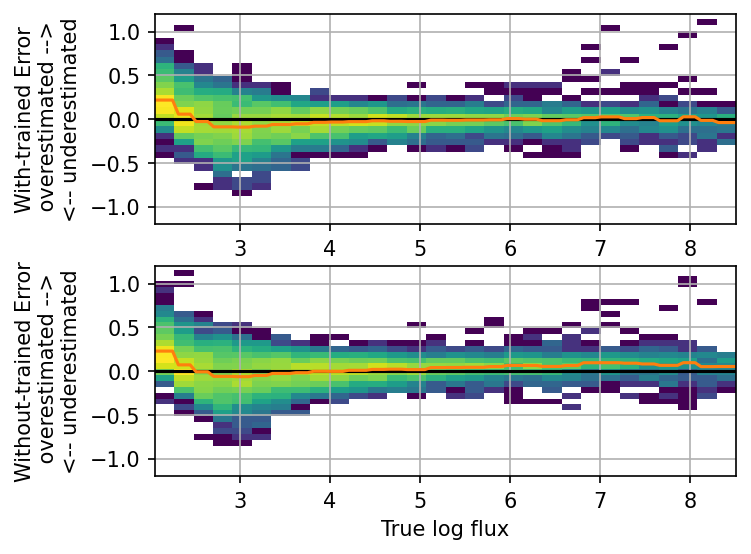

In [42]:
# compare errors as a function of true log flux
truth_range=np.r_[truths.min():truths.max():100j]

plt.gcf().set_size_inches(5,4)
plt.subplot(2,1,1)
plt.hist2d(truths.ravel(),(with_preds-truths).ravel(),bins=30,norm='log');
plt.axhline(0,color='black')
typical_err_fit=sklearn.base.clone(binsmoother).fit(truths.ravel()[:,None],(with_preds-truths).ravel())
plt.plot(truth_range,typical_err_fit.predict(truth_range[:,None]),color='C1')
plt.xlabel("True log flux")
plt.ylabel("With-trained Error\n overestimated -->\n<-- underestimated")
plt.ylim(-1.2,1.2)
plt.grid(True)

plt.subplot(2,1,2)
plt.hist2d(truths.ravel(),(without_preds-truths).ravel(),bins=30,norm='log');
plt.axhline(0,color='black')
typical_err_fit=sklearn.base.clone(binsmoother).fit(truths.ravel()[:,None],(without_preds-truths).ravel())
plt.plot(truth_range,typical_err_fit.predict(truth_range[:,None]),color='C1')
plt.xlabel("True log flux")
plt.ylabel("Without-trained Error\n overestimated -->\n<-- underestimated")
plt.ylim(-1.2,1.2)
plt.grid(True)

Is there a difference?  Maybe?  Especially for sources with large flux?

In [43]:
print("MSE of model trained with translation artifacts (on test data with translation artifacts)")
print(np.mean((truths-with_preds)**2))

print("and bias")
print(np.mean((truths-with_preds)))

print("\nMSE of model trained without translation artifacts (on test data with translation artifacts)")
print(np.mean((truths-without_preds)**2))

print("and bias")
print(np.mean((truths-without_preds)))

MSE of model trained with translation artifacts (on test data with translation artifacts)
0.033940338
and bias
0.00588898

MSE of model trained without translation artifacts (on test data with translation artifacts)
0.034921944
and bias
-0.030082306


Ok yes there is a difference, and as we might hope, if we 
* train network A on simulated data that *does* have translation artifacts
* train network B on simulated data that *doesnt* have translation artifacts
* network A does better (lower MSE) on data with *does* have translation artifacts.

Difference is nontrivial, something like 3%.

In [44]:
np.mean((truths-with_preds)**2)/np.mean((truths-without_preds)**2)

0.9718914

# Calibration

Although difference is nontrivial, we can probably remedy this.  Its fair to assume we have access to some stars with known flux we can use for a basic linear recalibration.  Let's see if that helps

In [46]:
# find results of both networks on small batch of 512 "real" images for which we images we have ground truth about flux.
# full network was trained on bazillions of images, we don't have that much ground truth data, but we probably do have
# a few hundred images where we really do already know the true fluxes (e.g. from Gaia).

testrng.manual_seed(0)
dl= dataloader.SimulatorDataset(prior,forward_model,testrng,batch_size=512,epoch_size=1)

batch=next(iter(dl))
X,Y = batch
truths=Y.cpu().numpy()
with_preds=inf_net_trained_with.predict(X).detach().cpu().numpy()
without_preds=inf_net_trained_without.predict(X).detach().cpu().numpy()

In [47]:
# add linear post-network linear calibration based on those real images

with_linfit=sklearn.linear_model.LinearRegression().fit(with_preds.ravel()[:,None],truths.ravel())
without_linfit=sklearn.linear_model.LinearRegression().fit(without_preds.ravel()[:,None],truths.ravel())

In [48]:
# check performance
# get new test sims, and try using the post-network linear calibraiton
dl= dataloader.SimulatorDataset(prior,forward_model,testrng,batch_size=64,epoch_size=64)

with_preds=[] # predictions made by network trained with artifacts (log flux)
without_preds=[] # predictions made by network trained without artifacts (log flux)
truths=[] # true log fluxes of both stars

# do network
for batch in tqdm.notebook.tqdm(dl):
    X,Y = batch
    truths.append(Y.cpu().numpy())
    with_preds.append(inf_net_trained_with.predict(X).detach().cpu().numpy())
    without_preds.append(inf_net_trained_without.predict(X).detach().cpu().numpy())
with_preds=np.concatenate(with_preds)
without_preds=np.concatenate(without_preds)
truths=np.concatenate(truths)

# do calibration step
with_preds=with_linfit.predict(with_preds.ravel()[:,None]).reshape(with_preds.shape)
without_preds=without_linfit.predict(without_preds.ravel()[:,None]).reshape(without_preds.shape)

  0%|          | 0/64 [00:00<?, ?it/s]

In [49]:
print("MSE of model trained with translation artifacts (on test data with translation artifacts)")
print(np.mean((truths-with_preds)**2))

print("and bias")
print(np.mean((truths-with_preds)))

print("\nMSE of model trained without translation artifacts (on test data with translation artifacts)")
print(np.mean((truths-without_preds)**2))

print("and bias")
print(np.mean((truths-without_preds)))

MSE of model trained with translation artifacts (on test data with translation artifacts)
0.032152504
and bias
0.0055760937

MSE of model trained without translation artifacts (on test data with translation artifacts)
0.03207641
and bias
0.008099282


After this calibration step, the difference between them is really pretty small, less than 1%.  And, actually, the network trained on the "bad" simulation actually does slightly better in total MSE.

In [50]:
np.mean((truths-with_preds)**2)/np.mean((truths-without_preds)**2)

1.0023723

Text(0.5, 0, 'True log flux')

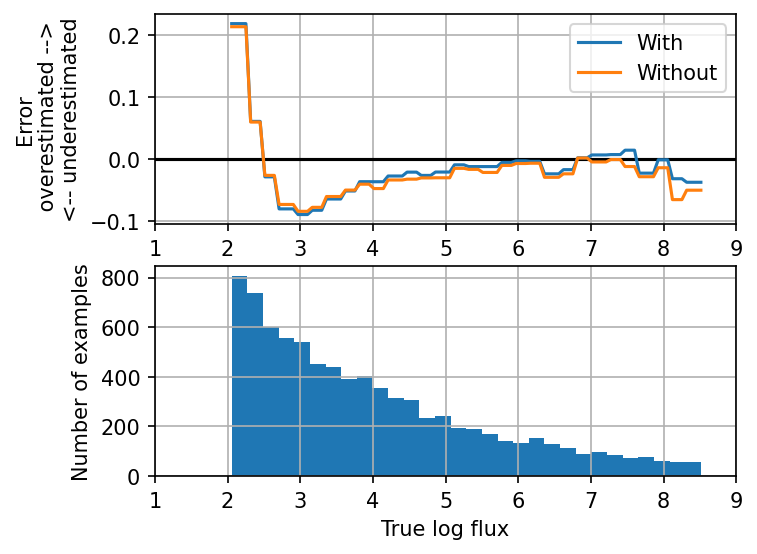

In [81]:
# compare errors as a function of true log flux
truth_range=np.r_[truths.min():truths.max():100j]

plt.gcf().set_size_inches(5,4)

plt.subplot(2,1,1)
plt.axhline(0,color='black')

typical_err_fit=sklearn.base.clone(binsmoother).fit(truths.ravel()[:,None],(with_preds-truths).ravel())
plt.plot(truth_range,typical_err_fit.predict(truth_range[:,None]),label='With')

typical_err_fit=sklearn.base.clone(binsmoother).fit(truths.ravel()[:,None],(without_preds-truths).ravel())
plt.plot(truth_range,typical_err_fit.predict(truth_range[:,None]),label='Without')

plt.ylabel("Error\n overestimated -->\n<-- underestimated")
plt.grid(True)
plt.xlim(1,9)

plt.legend()

plt.subplot(2,1,2)
plt.hist(truths.ravel(),bins=30);

plt.xlim(1,9)
plt.grid(True)

plt.ylabel("Number of examples")

plt.xlabel("True log flux")

"With" model does slightly better on high-flux examples, but slightly worse on low-flux examples....and there are a lot more low-flux examples.

There's no winner here, suggesting that---at least if you perform a post-training calibration step---it is not important to include translation artifacts in your sims to get good inference networks in the context of SBI. 

One direction to explore: a pre-training calibration step, again using a few hundred example images where ground truth is known, to get the no-translation-artifact-simulator "as close as possible" to the real data.  This precalibration step would be in the service of making the *simulator* as accurate as possible.  That might also lead to similar performance regardless of whether sim includes translation artifacts, and might not require a post-training calibration step (which is in the service of tweaking the output of the *inference network* to get more accurate results).  

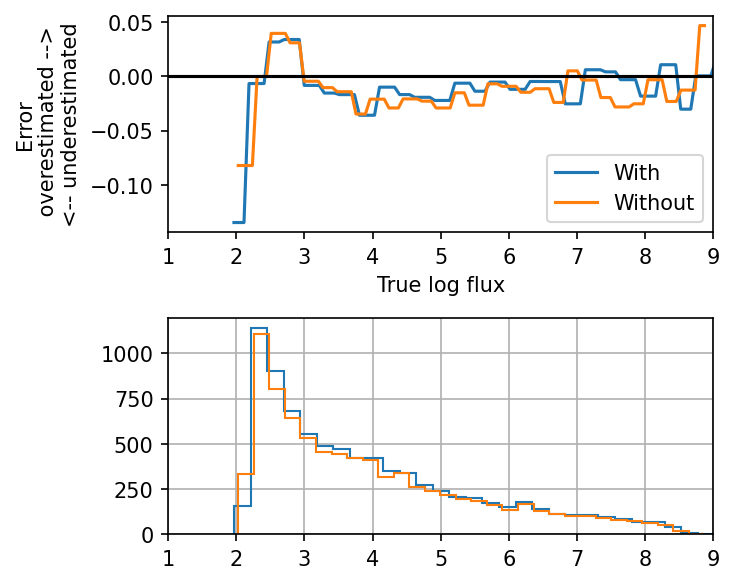

In [82]:
# it can also be revealing to reverse the axes to show how error depends on what prediction we make


plt.gcf().set_size_inches(5,4)

plt.subplot(2,1,1)
preds_range=np.r_[with_preds.min():with_preds.max():100j]
typical_pred_fit=sklearn.base.clone(binsmoother).fit(with_preds.ravel()[:,None],with_preds.ravel()-truths.ravel())
plt.plot(preds_range,typical_pred_fit.predict(truth_range[:,None]),label='With')

preds_range=np.r_[without_preds.min():without_preds.max():100j]
typical_pred_fit=sklearn.base.clone(binsmoother).fit(without_preds.ravel()[:,None],without_preds.ravel()-truths.ravel())
plt.plot(preds_range,typical_pred_fit.predict(truth_range[:,None]),label='Without')

plt.xlim(1,9)

plt.ylabel("Error\n overestimated -->\n<-- underestimated")

plt.legend()

plt.axhline(0,color='black')
plt.xlabel("True log flux")

plt.subplot(2,1,2)
plt.hist(with_preds.ravel(),bins=30,histtype='step',label='With');
plt.hist(without_preds.ravel(),bins=30,histtype='step',label='Without');
plt.grid(True)

plt.subplot(2,1,2)

plt.xlim(1,9)

plt.tight_layout();

Broadly they do equally well.  They both do quite badly in a few weird cases where they predict very small fluxes (around 2).  Those very small fluxes are typically *underestimates*, for both methods.  A weird form of error for both, presumably due to a relatively small number of cases with such small sizes.  This may be an artificial phenomena, due to the truncated pareto distribution.